# Smart Citizen - sensores electrónicos fijos de monitoreo de la calidad del aire

#### Importamos los módulos que vamos a necesitar para utilizar el notebook de forma correcta

In [18]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline


#graph
import datetime
import textwrap

#### A continuación, se descarga el estilo que se utiliza desde GitHub

In [26]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']

#### Con [OSMnx](https://osmnx.readthedocs.io/en/stable/) se descarga la red vial para el área de los sensores

In [3]:
G = ox.graph_from_bbox(20.7900,20.523110,-103.2400,-103.4700)
edges = ox.graph_to_gdfs(G, nodes=False)

#### Utilizando el módulo de aqiGDL de [PIP](https://github.com/derive-LAB/PIP_CiudadFuturo) podemos acceder a los datos de calidad del aire para los sensores electrónicos de [Smart Citizen](https://smartcitizen.me/kits/) que se utilizaron en el proyecto

In [4]:
gdf = aqiGDL.gdf_from_db('smartcitizen', 'public')
gdf

,device_id,param,unit,lon,lat,date,value,geometry
0,13483,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.351588,20.685147,2021-03-03T15:00:38Z,23628.451613,POINT (671692.111 2288175.175)
1,13483,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.351588,20.685147,2021-03-03T14:00:08Z,29206.000000,POINT (671692.111 2288175.175)
2,13483,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.351588,20.685147,2021-03-03T13:00:51Z,29206.000000,POINT (671692.111 2288175.175)
3,13483,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.351588,20.685147,2021-03-03T12:00:49Z,29206.000000,POINT (671692.111 2288175.175)
4,13483,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.351588,20.685147,2021-03-03T11:00:50Z,29206.000000,POINT (671692.111 2288175.175)
...,...,...,...,...,...,...,...,...
277281,13772,Temperature,ºC,-103.413618,20.668877,2021-02-21T01:00:32Z,19.480167,POINT (665247.641 2286309.678)
277282,13772,Temperature,ºC,-103.413618,20.668877,2021-02-21T00:00:26Z,19.575833,POINT (665247.641 2286309.678)
277283,13772,Temperature,ºC,-103.413618,20.668877,2021-02-20T23:00:16Z,19.710333,POINT (665247.641 2286309.678)
277284,13772,Temperature,ºC,-103.413618,20.668877,2021-02-20T22:00:12Z,19.777000,POINT (665247.641 2286309.678)


Generamos una nueva tabla únicamente con los datos de los sensores, sus coordenadas y la geometría.

In [5]:
gdf_est = gdf[['device_id','lon','lat']].groupby('device_id').mean()
gdf_est = gpd.GeoDataFrame(
    gdf_est, geometry=gpd.points_from_xy(gdf_est.lon, gdf_est.lat))
gdf_est.head(2)

,lon,lat,geometry
device_id,,,
13483,-103.351588,20.685147,POINT (-103.35159 20.68515)
13492,-103.389891,20.651647,POINT (-103.38989 20.65165)


Desde nuestra tabla original, y utilizando el argumento unique, podemos observar cuales son los parámetros que los sensores de Smart Citizen están registrando para cada ubicación. Estos los vamos a utilizar más adelante para graficar el comportamiento de la contaminación en distintos puntos.

In [6]:
gdf['param'].unique()

array(['Total Volatile Organic Compounds Digital Indoor Sensor',
       'Equivalent Carbon Dioxide Digital Indoor Sensor',
       'Digital Ambient Light Sensor', 'Custom Circuit',
       'I2S Digital Mems Microphone with custom Audio Processing Algorithm',
       'Digital Barometric Pressure Sensor', 'Particle Matter PM 1',
       'Particle Matter PM 10', 'Particle Matter PM 2.5', 'Humidity',
       'Temperature'], dtype=object)

De igual forma, con unique, podemos ver todos los identificadores de sensores que tenemos.

In [7]:
gdf.device_id.unique()

array([13483, 13492, 13507, 13545, 13548, 13573, 13574, 13598, 13647,
       13689, 13702, 13771, 13772])

Podemos hacer una prueba de filtrado de los datos de nuestra tabla original utilizando como filtro uno de los parámetros y de los identificadores de los sensores

In [8]:
gdf_param = gdf.loc[(gdf.param=='Total Volatile Organic Compounds Digital Indoor Sensor')&(gdf.device_id==13483)]
gdf_param.head(2)

,device_id,param,unit,lon,lat,date,value,geometry
0,13483,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.351588,20.685147,2021-03-03T15:00:38Z,23628.451613,POINT (671692.111 2288175.175)
1,13483,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.351588,20.685147,2021-03-03T14:00:08Z,29206.000000,POINT (671692.111 2288175.175)


Debido a que las fechas tienen una mayor resolución temporal de la que necesitamos, vamos a hacer un tratamiento de datos para que queden agrupados por día y nos muestre los promedios diarios.

In [9]:
pd.options.mode.chained_assignment = None
gdf_param['date'] = pd.to_datetime(gdf_param['date'])
gdf_param.set_index('date',inplace=True)
gdf_param = gdf_param.resample('D').mean()
gdf_param.head(2)

,device_id,lon,lat,value
date,,,,
2021-01-20 00:00:00+00:00,13483,-103.351588,20.685147,5225.986176
2021-01-21 00:00:00+00:00,13483,-103.351588,20.685147,12431.568545


Podemos visualizar distintas agrupaciones de los datos utilizando rolling, que nos permite hacer promedios móviles en ventanas específicas. En este caso, vamos a seleccionar promedios cada tercer día. Es posible observar que los primeros dos valores no tienen datos debido a que no cumplen con el valor mínimo establecido de 3.

In [10]:
gdf_param.rolling(3).mean().head(5)

,device_id,lon,lat,value
date,,,,
2021-01-20 00:00:00+00:00,NaN,NaN,NaN,NaN
2021-01-21 00:00:00+00:00,NaN,NaN,NaN,NaN
2021-01-22 00:00:00+00:00,13483.0,-103.351588,20.685147,7519.995688
2021-01-23 00:00:00+00:00,13483.0,-103.351588,20.685147,9804.676416
2021-01-24 00:00:00+00:00,13483.0,-103.351588,20.685147,10744.771708


Con los datos de fecha y de concentración en gdf_param podemos hacer una visualización rápida en la que tenemos en las "y" las concentraciones de compuestos orgánicos volátiles y en "x" nuestras fechas.

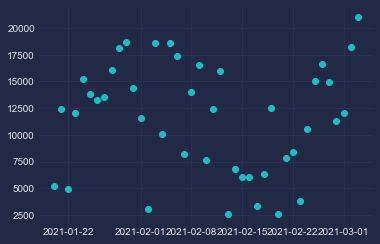

In [11]:
plt.scatter(gdf_param.index, gdf_param['value'])

Para hacer visualizaciones más avanzadas podemos utilizar la siguiente función, en la que tenemos como datos de entrada el número de dispositivo, el parámetro de interés, el GeoDataFrame descargado directamente de la base de datos de PIP, el GeoDataFrame que creamos previamente para las estaciones y las vialidades descargadas de OSMnx. Además, podemos determinar si queremos que la gráfica resultante se guarde.

In [23]:
def graph_smartcitizen(device, param, gdf, gdf_est, edges, save=False):

    fig, axes = plt.subplots(1,2,figsize=(24,8), sharex=True)

    df_temp = gdf[(gdf['device_id']==device) & (gdf['param']==param)].copy()
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    df_temp.set_index('date',inplace=True)
    df_temp = df_temp.resample('D').mean()
    axes[1].scatter(df_temp.index, df_temp['value'], label=param)

    title = textwrap.fill(param, 35)
    axes[1].set_title(title,fontsize=20)
    axes[1].tick_params(axis='x',labelrotation=45)


    x_ticks = np.arange(0, len(df_temp.index),15)

    a00 = axes[0]
    shax = a00.get_shared_x_axes()
    shax.remove(a00)
    edges.plot(ax=axes[0], color='#e8e9eb',linewidth=0.1, zorder=-1)
    edges[(edges['highway']=='primary') | (edges['highway']=='secondary')].plot(ax=axes[0], color='#e8e9eb',linewidth=0.5, zorder=0)
    gdf_est.plot(ax=axes[0], color='k', alpha=0.85, zorder=1)
    gdf_est[gdf_est.index==device].plot(ax=axes[0], color='#ba0d38', alpha=0.85, zorder=2, markersize=90)
    axes[0].axis('off')
    estacion = device
    fecha_1 = df_temp.index.min().strftime("%Y-%m-%d")
    fecha_2 = df_temp.index.max().strftime("%Y-%m-%d")
    fig.suptitle(f'Device: {estacion}\n{fecha_1} -- {fecha_2}', fontsize=30)

    if save==True:
        plt.savefig(f'{device}_{fecha_1}_{fecha_2}.png',dpi=300)

    return plt.show()

In [21]:
est = 13483
param = 'Particle Matter PM 10'

Corriendo esta función podemos ver la localización del sensor que estamos analizando y su referencia con los otros sensores aunado a la distribución de los contaminantes por día.

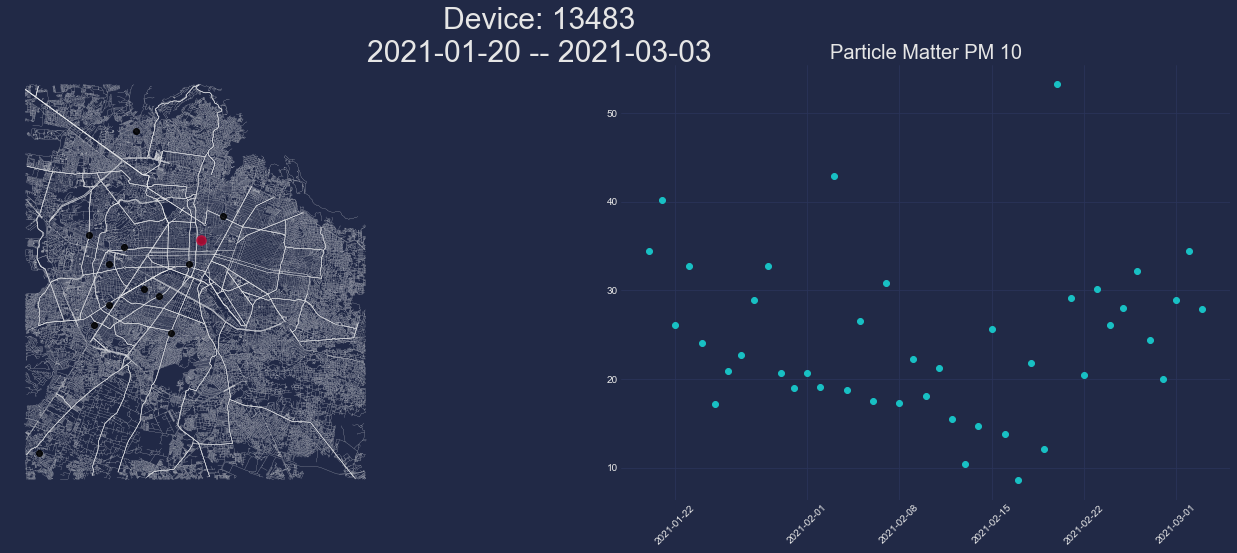

In [27]:
graph_smartcitizen(est, param, gdf, gdf_est, edges, save=False)